# Tutorial: Generating type Ia supernova lightcurves based on ztf_sim output 

This notebook shows how to load the output for Eric's survey simulator `ztf_sim` and generate SN Ia lightcurves using the SALT2 template. (Check out the other notebooks for examples how to simulate other transients.)

*Note:* You need to download Eric's newest sample output [here](https://drive.google.com/file/d/1sB6r21ALG7ZKetvE734JS-UpLa3iwWSz/view). The link was also included in Eric's email, so you will likely only need to change the path below.

Furthermore you'll require the dust map from Schlegel, Finkbeiner & Davis (1998) for full functionality. It can be found [here](https://github.com/kbarbary/sfddata/archive/master.tar.gz).

In [1]:
import os
home_dir = os.environ.get('HOME')

# Please enter the filename of the ztf_sim output file you would like to use. The example first determines
# your home directory and then uses a relative path (useful if working on several machines with different usernames)
survey_file = os.path.join(home_dir, 'data/ZTF/test_schedule_v6.db')

# Please enter the path to where you have placed the Schlegel, Finkbeiner & Davis (1998) dust map files
# You can also set the environment variable SFD_DIR to this path (in that case the variable below should be None)
sfd98_dir = os.path.join(home_dir, 'data/sfd98')

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import simsurvey
import sncosmo
from astropy.cosmology import Planck15

import simsurvey_tools as sst 

In [3]:
# Load the ZTF CCD corners and filters
ccds = sst.load_ztf_ccds()
sst.load_ztf_filters()

In [4]:
# Load simulated survey from file (download from ftp://ftp.astro.caltech.edu/users/ebellm/one_year_sim_incomplete.db)
# Currently DES filters are used as proxies for ZTF filters
plan = simsurvey.SurveyPlan(load_opsim=survey_file, band_dict={'g': 'ztfg', 'r': 'ztfr', 'i': 'desi'}, ccds=ccds)

mjd_range = (plan.cadence['time'].min() - 30, plan.cadence['time'].max() + 30)

In [5]:
# To review the pointing schedule, you can use this table
plan.pointings

time,band,zp,skynoise,RA,Dec,field,comment
float64,str4,int64,float64,float64,float64,int64,unicode13
57433.16732874228,ztfr,30,1235.458254793129,97.27032,-24.25,258,all_sky
57433.167791705244,ztfr,30,1032.4155614033896,93.69218000000001,-17.05,307,all_sky
57433.16825466821,ztfr,30,831.1606554753829,96.84022,-9.85,358,all_sky
57433.16874926458,ztfr,30,768.014325534311,89.36968,4.55,459,all_sky
57433.16922019285,ztfr,30,754.6151413469311,85.58463,11.75,511,all_sky
57433.169683155815,ztfr,30,845.7393295485028,82.3588,4.55,458,all_sky
57433.170146118784,ztfr,30,754.6151413469311,85.58463,11.75,511,all_sky
57433.170609081746,ztfr,30,717.2561184374863,88.37309,18.95,562,nightly_plane
57433.171118378836,ztfr,30,666.0616637410405,91.24686,26.15,612,all_sky


## TransientGenerator
The transient generator combines a model and a distribution representing the transient population, and randomly draws all parameters needed to simulate the lightcurves. For well studied transient types, e.g. SNe Ia, models and generators have been predefined for easy use.

Here the maximum redshift has been kept very low in order make the simulation short. In reality $z_{max} = 0.2$ would be more realistic.

In [6]:
tr = simsurvey.get_transient_generator((0.0, 0.05),
                                       transient='Ia',
                                       template='salt2',
                                       dec_range=(-30,90),
                                       mjd_range=(mjd_range[0],
                                                  mjd_range[1]),
                                       sfd98_dir=sfd98_dir)

## SimulSurvey
Lastly, all parts are combined in a SimulSurvey object that will generate the lightcurves.
(This may take about a minute or two.)

In [7]:
survey = simsurvey.SimulSurvey(generator=tr, plan=plan)
    
lcs = survey.get_lightcurves(
    #progress_bar=True, notebook=True # If you get an error because of the progress_bar, delete this line.
)

/home/ufeindt/.local/lib/python2.7/site-packages/simsurvey-0.4.0-py2.7.egg/simsurvey/simulsurvey.py:1355: RuntimeWarning: invalid value encountered in log10


In [8]:
len(lcs.lcs)

350

In [9]:
lcs[0]

time,band,flux,fluxerr,zp,zpsys,field,ccd,comment
float64,str4,float64,float64,int64,str2,int64,int64,unicode7
57551.445018122424,ztfg,2024.0255338498682,436.78312004535195,30,ab,690,8,all_sky
57551.47332394582,ztfr,2339.522439281221,491.04553618173026,30,ab,690,8,all_sky
57552.42489128937,ztfr,11281.8666337656,472.89603857374533,30,ab,690,8,all_sky
57552.44623390818,ztfg,8664.782710347088,443.0017023078733,30,ab,690,8,all_sky
57552.46824813182,ztfr,11440.430928533457,500.1070037642086,30,ab,690,8,all_sky
57552.468711094785,ztfr,12106.589403582266,500.11261609355654,30,ab,690,8,all_sky
57553.446264031285,ztfg,23149.665153266586,459.0185909022281,30,ab,690,8,all_sky
57553.47789399839,ztfr,27503.32176647366,515.259341641885,30,ab,690,8,all_sky
57553.47835696135,ztfr,28041.069004076533,515.268082280036,30,ab,690,8,all_sky


## Analysing the output

The output of `get_lightcurves()` is a `LightcurveCollection` object. Lightcurves are automatically filter, so only those that would be detected in the survey are kept.

You can save a the lightcurves in a pickle file and load them again later without rerunning the simulation.

In [10]:
lcs.save('lcs_tutorial.pkl')

In [11]:
lcs = simsurvey.LightcurveCollection(load='lcs_tutorial.pkl')

You can inspect the lightcurves manually. This example should return the lightcurve with the most points with S/N > 5.

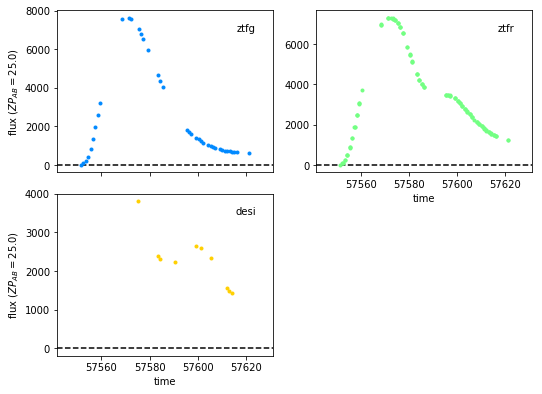

In [12]:
_ = sncosmo.plot_lc(lcs[0])

The two figures below show how early the MNe are detected and at what redshifts. The simulation input parameters of transients that were not detected are also kept, so can check completeness. 

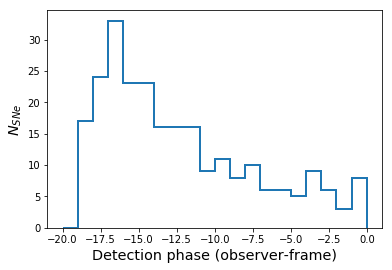

In [13]:
plt.hist(lcs.stats['p_det'], lw=2, histtype='step', range=(-20,0), bins=20)
plt.xlabel('Detection phase (observer-frame)', fontsize='x-large')
_ = plt.ylabel(r'$N_{SNe}$', fontsize='x-large')

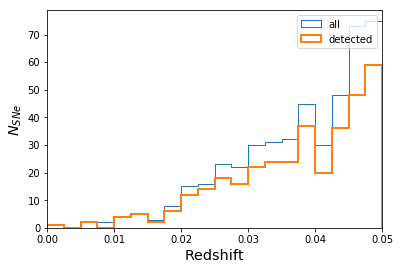

In [14]:
plt.hist(lcs.meta_full['z'], lw=1, histtype='step', range=(0,0.05), bins=20, label='all')
plt.hist(lcs.meta['z'], lw=2, histtype='step', range=(0,0.05), bins=20, label='detected')
plt.xlabel('Redshift', fontsize='x-large')
plt.ylabel(r'$N_{SNe}$', fontsize='x-large')
plt.xlim((0, 0.05))
plt.legend()